# Transformer - Attention is all you need

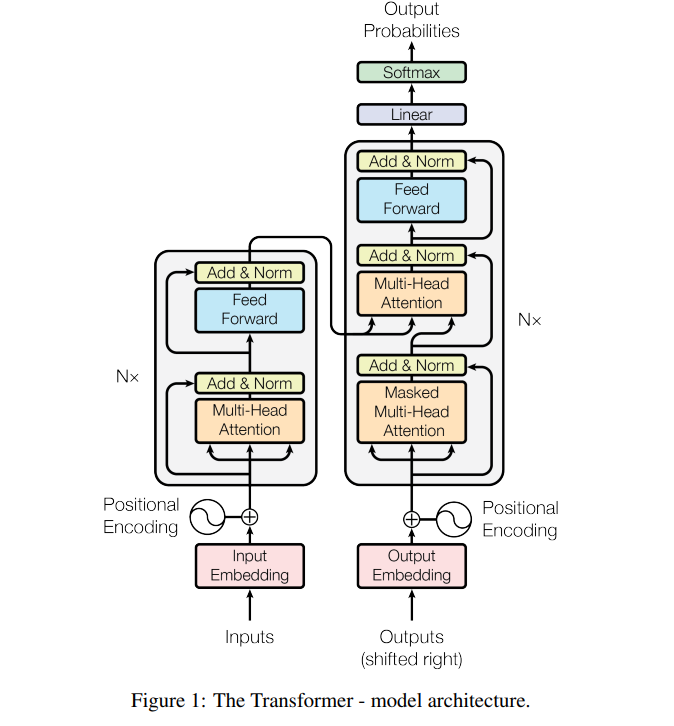

## Configuration


### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import math

### Device

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Global Vars

In [3]:
MAX_SEQ_LEN = 128
# Semilla
torch.manual_seed(23)

---
## Classes of Transformer model

### PositionalEmbedding

In [ ]:
class PositionalEmbedding(nn.Module):
    def __init__ (self, d_model, max_seq_len=MAX_SEQ_LEN):
        super().__init__()
        
        # Initialize a matrix for positional embeddings with zeros.
        # The matrix shape is (max_seq_len, d_model) and is allocated on the specified device.
        self.pos_embed_matrix = torch.zeros(max_seq_len, d_model, device=device)
        
        # Create a tensor containing positions [0, 1, 2, ..., max_seq_len-1] and reshape it to a column vector.
        token_pos = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
        
        # Compute the division term for the sinusoidal functions.
        # This scales the frequencies for each dimension of the embedding.
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        # Assign sinusoidal values to the even indices of the positional embedding matrix.
        self.pos_embed_matrix[:, 0::2] = torch.sin(token_pos * div_term)
        # Assign cosine values to the odd indices of the positional embedding matrix.
        self.pos_embed_matrix[:, 1::2] = torch.cos(token_pos * div_term)
        
        # Add an extra dimension for batch compatibility and transpose to match the expected input shape.
        self.pos_embed_matrix = self.pos_embed_matrix.unsqueeze(0).transpose(0, 1)
        
        
    def forward(self, x):
        # Add the positional embeddings to the input tensor.
        # The slicing ensures that the positional embeddings match the sequence length of the input.
        return x + self.pos_embed_matrix[:x.size(0), :]



### PositionFeedForward

In [ ]:
class PositionFeedForward(nn.Module):
    def __init__(self, d_model, dim_feedforward):
        super().__init__()
        
        # Define the first linear layer that projects from the model dimension to the feedforward dimension.
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        # Define the second linear layer that projects from the feedforward dimension back to the model dimension.
        self.linear2 = nn.Linear(dim_feedforward, d_model)
    
    
    def forward(self, x):
        # Apply the first linear transformation to the input, then the GELU activation function,
        # and finally apply the second linear transformation to produce the output.
        return self.linear2(F.gelu(self.linear1(x)))


### MultiHeadAttention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=512, n_heads=8):
        super().__init__()
        
        # Ensure that the model dimension is evenly divisible by the number of attention heads.
        assert d_model % n_heads == 0, 'Embedding size not compatible with number of heads'
        
        # Calculate the dimensionality for each head's value (and key) vector.
        self.d_v = d_model // n_heads
        self.d_k = self.d_v  # For simplicity, key dimension is set equal to value dimension.
        self.n_heads = n_heads
        
        # Define linear layers to project the input embeddings to queries, keys, and values.
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        # Define a linear layer to combine the outputs from all attention heads.
        self.W_o = nn.Linear(d_model, d_model)    
    
    def forward(self, Q, K, V, mask=None):
        '''
        Q, K, V: [batch_size, seq_len, d_model (n_heads * d_k)]
        After projection and reshaping, Q, K, V become:
        [batch_size, n_heads, seq_len, d_k]
        '''
        # Extract the batch size from the input tensor.
        batch_size = Q.size(0)
        
        # Project Q with a linear layer, then reshape and transpose to separate heads.
        Q = self.W_q(Q).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        # Project K similarly.
        K = self.W_k(K).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        # Project V similarly.
        V = self.W_v(V).view(batch_size, -1, self.n_heads, self.d_k).transpose(1, 2)
        
        # Compute scaled dot-product attention on the multi-head representations.
        weighted_values, attention = self.scaled_dot_product(Q, K, V, mask)
        
        # Transpose back to [batch_size, seq_len, n_heads, d_k] and reshape to [batch_size, seq_len, d_model].
        weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.n_heads * self.d_k)
        # Apply the output linear transformation to mix the heads.
        weighted_values = self.W_o(weighted_values)
        
        # Return the final output along with the attention weights.
        return weighted_values, attention
        
    def scaled_dot_product(self, Q, K, V, mask=None):
        # Compute raw attention scores by taking the dot product between Q and K transpose, scaled by sqrt(d_k).
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        # If a mask is provided, set the scores of the masked positions to a large negative value.
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        # Apply softmax to obtain the attention probabilities.
        attention = F.softmax(scores, dim=-1)
        # Multiply the attention weights with V to get the weighted values.
        weighted_values = torch.matmul(attention, V)
        
        # Return both the weighted values and the attention weights.
        return weighted_values, attention


### Encoder

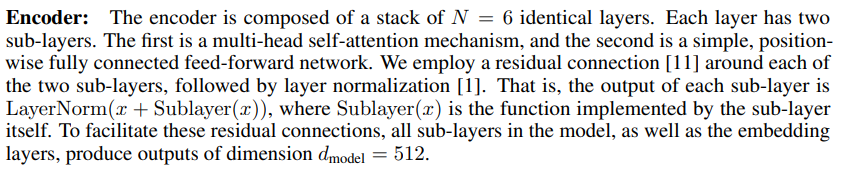

#### EncoderSubLayer

In [ ]:
class EncoderSubLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout = 0.1):
        super().__init__()
        # Initialize the multi-head self-attention module.
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        # Initialize the position-wise feed-forward network.
        self.ffn = PositionFeedForward(d_model, d_ff)
        # Layer normalization applied after the self-attention sub-layer (with residual connection).
        self.norm1 = nn.LayerNorm(d_model)
        # Layer normalization applied after the feed-forward sub-layer (with residual connection).
        self.norm2 = nn.LayerNorm(d_model)
        # Dropout applied to the output of the self-attention layer before the residual addition.
        self.droupout1 = nn.Dropout(dropout)
        # Dropout applied to the output of the feed-forward network before the residual addition.
        self.droupout2 = nn.Dropout(dropout)
    
    def forward(self, x, mask = None):
        # Apply self-attention on input x, using x as query, key, and value.
        attention_score, _ = self.self_attn(x, x, x, mask)
        # Add dropout to the attention output and combine it with the input via a residual connection.
        x = x + self.droupout1(attention_score)
        # Normalize the combined output.
        x = self.norm1(x)
        # Pass the normalized tensor through the feed-forward network, apply dropout, and add via a residual connection.
        x = x + self.droupout2(self.ffn(x))
        # Apply a final layer normalization and return the result.
        return self.norm2(x)


#### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, d_model, n_head, dim_feedforward, num_layers, dropout=0.1):
         super().__init__()
         
         # Create a list of encoder sub-layers. Each sub-layer contains a self-attention mechanism,
         # a position-wise feed-forward network, and residual connections with layer normalization.
         self.layers = nn.ModuleList([
             EncoderSubLayer(d_model, n_head, dim_feedforward, dropout) 
             for _ in range(num_layers)
         ])
         # Final layer normalization to be applied after passing through all encoder sub-layers.
         self.norm = nn.LayerNorm(d_model)
         
    
    def forward(self, x, mask=None):
        # Sequentially apply each encoder sub-layer to the input.
        for layer in self.layers:
            x = layer(x, mask)
            
        # Apply final layer normalization to the output of the last encoder sub-layer.
        return self.norm(x)


### Decoder

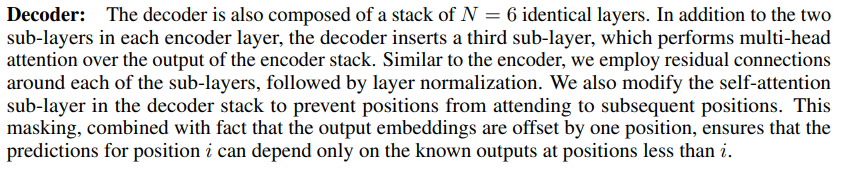



#### DecoderSubLayer

In [ ]:
class DecoderSubLayer(nn.Module):
    def __init__(self, d_model, n_heads, dim_feedforward, dropout=0.1):
        super().__init__()
        
        # Initialize self-attention for the decoder, which attends only to previous positions.
        self.self_attn = MultiHeadAttention(d_model, n_heads)
        # Initialize cross-attention to attend to the encoder output.
        self.cross_attn = MultiHeadAttention(d_model, n_heads)
        # Initialize the position-wise feed-forward network.
        self.feed_forward = PositionFeedForward(d_model, dim_feedforward)
        
        # Layer normalization applied after self-attention with residual connection.
        self.norm1 = nn.LayerNorm(d_model)
        # Layer normalization applied after cross-attention with residual connection.
        self.norm2 = nn.LayerNorm(d_model)
        # Layer normalization applied after the feed-forward network with residual connection.
        self.norm3 = nn.LayerNorm(d_model)
        
        # Dropout for self-attention output before adding the residual.
        self.dropout1 = nn.Dropout(dropout)
        # Dropout for cross-attention output before adding the residual.
        self.dropout2 = nn.Dropout(dropout)
        # Dropout for feed-forward output before adding the residual.
        self.dropout3 = nn.Dropout(dropout)
        
        
    def forward(self, x, encoder_output, target_mask=None, encoder_mask=None):
        # Apply self-attention on the target sequence with an optional mask to prevent future token access.
        attention_score, _ = self.self_attn(x, x, x, mask=target_mask)
        # Add dropout to self-attention output and combine it with the original input (residual connection).
        x = x + self.dropout1(attention_score)
        # Normalize the combined output.
        x = self.norm1(x)
        
        # Apply cross-attention, where queries come from the decoder (x) and keys/values come from the encoder output.
        encoder_attention_score, _ = self.cross_attn(x, encoder_output, encoder_output, mask=encoder_mask)
        # Add dropout to cross-attention output and combine it with the current state (residual connection).
        x = x + self.dropout2(encoder_attention_score)
        # Normalize the combined output.
        x = self.norm2(x)
        
        # Pass the result through the position-wise feed-forward network.
        feed_forward_output = self.feed_forward(x)
        # Add dropout to feed-forward output and combine it with the current state (residual connection).
        x = x + self.dropout3(feed_forward_output)
        # Normalize the final output.
        x = self.norm3(x)
        
        return x


#### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__ (self, d_model, n_head, dim_feedforward, num_layers, dropout=0.1):
        super().__init__()
        
        # Create a list of decoder sub-layers. Each layer integrates self-attention,
        # cross-attention with the encoder output, and a feed-forward network, all with residual connections.
        self.layers = nn.ModuleList([
            DecoderSubLayer(d_model, n_head, dim_feedforward, dropout) 
            for _ in range(num_layers)
        ])
        # Define a final layer normalization to be applied after all decoder layers.
        self.norm = nn.LayerNorm(d_model)
        
    
    def forward(self, x, encoder_output, target_mask, encoder_mask):
        # Sequentially pass the input through each decoder sub-layer.
        for layer in self.layers:
            x = layer(x, encoder_output, target_mask, encoder_mask)
            
        # Apply final layer normalization to stabilize the output representations.
        return self.norm(x)


### Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(
                self, 
                d_model, 
                n_head, 
                dim_feedforward, 
                num_layers, 
                input_vocab_size,
                target_vocab_size,
                max_seq_len=MAX_SEQ_LEN,
                dropout=0.1):
        
        super().__init__()
        
        # Create an embedding layer for the source vocabulary; maps token indices to d_model-dimensional vectors.
        self.encoder_embedding = nn.Embedding(input_vocab_size, d_model)
        # Create an embedding layer for the target vocabulary; maps token indices to d_model-dimensional vectors.
        self.decoder_embedding = nn.Embedding(target_vocab_size, d_model)
        # Initialize positional embeddings to inject information about token positions.
        self.pos_embedding = PositionalEmbedding(d_model, max_seq_len)
        # Instantiate the encoder composed of multiple EncoderSubLayers.
        self.encoder = Encoder(d_model, n_head, dim_feedforward, num_layers, dropout)
        # Instantiate the decoder composed of multiple DecoderSubLayers.
        self.decoder = Decoder(d_model, n_head, dim_feedforward, num_layers, dropout)
        # Final linear layer to project the decoder outputs to the target vocabulary dimension.
        self.output_layer = nn.Linear(d_model, target_vocab_size)
    
    
    def forward(self, source, target):
        # Generate masks for the encoder and decoder based on non-zero tokens.
        encoder_mask, target_mask = self.mask(source, target)
        
        # Embed the source tokens and scale by the square root of the embedding dimension.
        source = self.encoder_embedding(source) * math.sqrt(self.encoder_embedding.embedding_dim)
        # Add positional encodings to the source embeddings.
        source = self.pos_embedding(source)
        # Process the source embeddings through the encoder.
        encoder_output = self.encoder(source, encoder_mask)
        
        # Embed the target tokens and scale similarly.
        target = self.decoder_embedding(target) * math.sqrt(self.encoder_embedding.embedding_dim)
        # Add positional encodings to the target embeddings.
        target = self.pos_embedding(target)
        # Process the target embeddings through the decoder, attending to the encoder output.
        decoder_output = self.decoder(target, encoder_output, target_mask, encoder_mask)
        
        # Project the decoder outputs to the target vocabulary to obtain logits.
        return self.output_layer(decoder_output)
        
    
    def mask(self, source, target):
        # Create a mask for the source sequence where tokens equal to 0 (padding) are masked out.
        source_mask = (source != 0).unsqueeze(1).unsqueeze(2)
        # Create a similar mask for the target sequence.
        target_mask = (target != 0).unsqueeze(1).unsqueeze(2)
        # Determine the sequence length of the target.
        size = target.size(1)
        # Create a lower triangular mask to prevent the decoder from attending to future tokens.
        no_mask = torch.tril(torch.ones((1, size, size), device=device)).bool()
        # Combine the target mask with the lower triangular mask.
        target_mask = target_mask & no_mask
        
        return source_mask, target_mask


---
# Simple test

In [ ]:
# Define the sequence lengths for both source and target sequences.
seq_len_source = 10
seq_len_target = 10

# Define the batch size (number of sequences processed in parallel).
batch_size = 2

# Define the vocabulary sizes for the input (source) and target languages.
input_vocab_size = 50
target_vocab_size = 50

# Generate random source sequences.
# The tokens are random integers in the range [1, input_vocab_size) with shape (batch_size, seq_len_source).
source = torch.randint(1, input_vocab_size, (batch_size, seq_len_source))

# Generate random target sequences.
# The tokens are random integers in the range [1, target_vocab_size) with shape (batch_size, seq_len_target).
target = torch.randint(1, target_vocab_size, (batch_size, seq_len_target))

# Set hyperparameters for the Transformer model.
d_model = 512       # Dimensionality of the model (embedding size).
n_heads = 8         # Number of attention heads.
d_ff = 2048         # Dimensionality of the feed-forward network within the Transformer.
num_layers = 6      # Number of layers in both the encoder and decoder stacks.

# Instantiate the Transformer model.
# Note: MAX_SEQ_LEN must be defined elsewhere in the code.
model = Transformer(d_model, 
                    n_heads, 
                    d_ff, 
                    num_layers, 
                    input_vocab_size,
                    target_vocab_size,
                    max_seq_len=MAX_SEQ_LEN,
                    dropout=0.1)


In [ ]:
# Move the model and input tensors (source and target) to the designated device (e.g., CPU or GPU).
model = model.to(device)
source = source.to(device)
target = target.to(device)


In [ ]:
# Perform a forward pass through the Transformer model using the source and target sequences.
output = model(source, target)

In [ ]:
# Expected output shape is [batch, seq_len_target, target_vocab_size], i.e., [2, 10, 50] for this test.
print(f'ouput.shape {output.shape}')

ouput.shape torch.Size([2, 10, 50])


---
# Example - English to Spanish Translation

## Reading the data

In [ ]:
# Define the file path for the English-Spanish translation dataset.
PATH = "../Transformer/resources/eng-spa.txt"

# Open the file in read mode with UTF-8 encoding.
with open(PATH, 'r', encoding='utf-8')  as f:
    # Read all lines from the file.
    lines = f.readlines()
    
# For each line that contains a tab character (indicating a valid translation pair),
# strip any leading/trailing whitespace and split the line into two parts (English and Spanish).
eng_spa_pairs = [line.strip().split('\t') for line in lines if '\t' in line]

# Display the first 10 translation pairs from the dataset.
eng_spa_pairs[:10]

[['OK.', '¡Órale!'],
 ['No.', 'No.'],
 ['Go!', '¡Ya!'],
 ['No!', '¡No!'],
 ['Go!', '¡Fuera!'],
 ['Ah!', '¡Anda!'],
 ['Ow!', '¡Ay!'],
 ['Go!', '¡Sal!'],
 ['Hi.', '¡Hola!'],
 ['Go.', 'Vete.']]

## Prepare the data

In [ ]:
# Extract the English sentences from each translation pair.
eng_sentences = [pair[0] for pair in eng_spa_pairs]
# Extract the Spanish sentences from each translation pair.
spa_sentences = [pair[1] for pair in eng_spa_pairs]

# Print the first 5 English sentences.
print(eng_sentences[:5])
# Print the first 5 Spanish sentences.
print(spa_sentences[:5])


['OK.', 'No.', 'Go!', 'No!', 'Go!']
['¡Órale!', 'No.', '¡Ya!', '¡No!', '¡Fuera!']


## Functions

In [ ]:
def preprocess_sentence(sentence):
    # Convert the sentence to lowercase and remove any leading/trailing whitespace.
    sentence = sentence.lower().strip()
    # Replace one or more spaces with a single space.
    sentence = re.sub(r'[" "]+', ' ', sentence)
    # Replace accented characters with their non-accented counterparts.
    sentence = re.sub(r'[á]+', 'a', sentence)
    sentence = re.sub(r'[é]+', 'e', sentence)
    sentence = re.sub(r'[í]+', 'i', sentence)
    sentence = re.sub(r'[ó]+', 'o', sentence)
    sentence = re.sub(r'[ú]+', 'u', sentence)
    # Replace any character that is not a lowercase letter with a space.
    sentence = re.sub(r'[^a-z]+', ' ', sentence)
    # Remove any extra whitespace from the beginning or end of the sentence.
    sentence = sentence.strip()
    # Add start-of-sentence (<sos>) and end-of-sentence (<eos>) tokens.
    sentence = '<sos> ' + sentence + ' <eos>'
    return sentence

s1 = "¿Hola cómo estás?1@2"
print(s1)
print(preprocess_sentence(s1))


¿Hola cómo estás?1@2
<sos> hola como estas <eos>


In [ ]:
# Apply the preprocessing function to all English sentences.
eng_sentences = [preprocess_sentence(sentence) for sentence in eng_sentences]
# Apply the preprocessing function to all Spanish sentences.
spa_sentences = [preprocess_sentence(sentence) for sentence in spa_sentences]

# Print the first 5 preprocessed English sentences.
print(eng_sentences[:5])
# Print the first 5 preprocessed Spanish sentences.
print(spa_sentences[:5])


['<sos> ok <eos>', '<sos> no <eos>', '<sos> go <eos>', '<sos> no <eos>', '<sos> go <eos>']
['<sos> orale <eos>', '<sos> no <eos>', '<sos> ya <eos>', '<sos> no <eos>', '<sos> fuera <eos>']


In [ ]:
def build_vocab(sentences):
    # Create a flat list of words from all sentences by splitting each sentence into words.
    words = [word for sentence in sentences for word in sentence.split()]
    
    # Count the frequency of each word using Counter.
    word_count = Counter(words)
    
    # Sort the words by frequency in descending order.
    sorted_word_counts = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    
    # Create a word-to-index mapping, starting index at 2 (reserving 0 and 1 for special tokens).
    word2idx = {word: idx for idx, (word, _) in enumerate(sorted_word_counts, 2)}
    # Assign special token <pad> to index 0.
    word2idx['<pad>'] = 0
    # Assign special token <unk> (unknown) to index 1.
    word2idx['<unk>'] = 1
    
    # Create an index-to-word mapping by reversing the word-to-index dictionary.
    idx2word = {idx: word for word, idx in word2idx.items()}
    
    # Return both mappings.
    return word2idx, idx2word


In [21]:
eng_word2idx, eng_idx2word = build_vocab(eng_sentences)
spa_word2idx, spa_idx2word = build_vocab(spa_sentences)

In [ ]:
# Calculate the vocabulary size for English by counting the number of entries in the eng_word2idx dictionary.
eng_vocab_size = len(eng_word2idx)
# Calculate the vocabulary size for Spanish by counting the number of entries in the spa_word2idx dictionary.
spa_vocab_size = len(spa_word2idx)

# Print out the sizes of both vocabularies in a formatted string.
print(f'Vocabularies sizes: {eng_vocab_size}, {spa_vocab_size}')


Vocabularies sizes: 27933, 47339


## Dataset - Class

In [ ]:
class EngSpaDataset(Dataset):
    def __init__(self, eng_sentences, spa_sentences, eng_word2idx, spa_word2idx):
        # Initialize the dataset with lists of English and Spanish sentences
        # and their corresponding vocabulary-to-index mappings.
        self.eng_sentences = eng_sentences
        self.spa_sentences = spa_sentences
        self.eng_word2idx = eng_word2idx
        self.spa_word2idx = spa_word2idx
        
    def __len__(self):
        # Return the total number of sentence pairs in the dataset.
        return len(self.eng_sentences)
    
    def __getitem__(self, idx):
        # Retrieve the English and Spanish sentences at the given index.
        eng_sentence = self.eng_sentences[idx]
        spa_sentence = self.spa_sentences[idx]
        
        # Convert the English sentence into a list of token indices.
        # For each word in the sentence, get its corresponding index,
        # using the <unk> index if the word is not found.
        eng_idxs = [self.eng_word2idx.get(word, self.eng_word2idx['<unk>']) for word in eng_sentence.split()]
        # Convert the Spanish sentence into a list of token indices similarly.
        spa_idxs = [self.spa_word2idx.get(word, self.spa_word2idx['<unk>']) for word in spa_sentence.split()]
        
        # Return the English and Spanish token indices as PyTorch tensors.
        return torch.tensor(eng_idxs), torch.tensor(spa_idxs)


## Collate Function

In [ ]:
def collate_fn(batch):
    # Unzip the batch into two separate tuples: one for English sequences and one for Spanish sequences.
    eng_batch, spa_batch = zip(*batch)
    
    # For each English sequence, truncate it to the maximum allowed sequence length (MAX_SEQ_LEN)
    # and detach it from the current computation graph.
    eng_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in eng_batch]
    # Do the same for each Spanish sequence.
    spa_batch = [seq[:MAX_SEQ_LEN].clone().detach() for seq in spa_batch]
    
    # Pad the truncated English sequences so that all sequences in the batch have the same length.
    # 'batch_first=True' makes the padded tensor have shape [batch_size, seq_length].
    # The padding_value of 0 corresponds to the <pad> token.
    eng_batch = torch.nn.utils.rnn.pad_sequence(eng_batch, batch_first=True, padding_value=0)
    # Pad the Spanish sequences similarly.
    spa_batch = torch.nn.utils.rnn.pad_sequence(spa_batch, batch_first=True, padding_value=0)
    
    # Return the padded English and Spanish batches.
    return eng_batch, spa_batch


## Train Function

In [ ]:
def train(model, dataloader, loss_function, optimizer, epochs):
    # Set the model to training mode.
    model.train()
    
    # Loop over the number of epochs.
    for epoch in range(epochs):
        total_loss = 0  # Initialize the total loss for the current epoch.
        
        # Iterate over batches from the dataloader.
        for i, (eng_batch, spa_batch) in enumerate(dataloader):
            # Move the English and Spanish batches to the designated device (CPU/GPU).
            eng_batch = eng_batch.to(device)
            spa_batch = spa_batch.to(device)
            
            # Decoder preprocessing:
            # target_input: all tokens except the last token in each Spanish sentence,
            # used as input to the decoder (<sos> to before <eos>).
            target_input = spa_batch[:, :-1]
            # target_output: all tokens except the first token in each Spanish sentence,
            # reshaped into a 1D tensor, used as ground truth for loss computation.
            target_output = spa_batch[:, 1:].contiguous().view(-1)
            
            # Zero the gradients before performing a backward pass.
            optimizer.zero_grad()
            
            # Forward pass: run the model with English batch and target_input.
            output = model(eng_batch, target_input)
            # Reshape the model output so that each row corresponds to a token's prediction.
            output = output.view(-1, output.size(-1))
            
            # Compute the loss between the predicted output and the target output.
            loss = loss_function(output, target_output)
            
            # Backward pass: compute gradients of the loss with respect to model parameters.
            loss.backward()
            # Update model parameters based on the computed gradients.
            optimizer.step()
            
            # Accumulate the loss for the current epoch.
            total_loss += loss.item()
            
        # After each epoch, print the average loss for that epoch.
        print(f'Epoch {epoch + 1}/{epochs}: Loss: {total_loss / len(dataloader)}')


## Train

In [ ]:
# Define the batch size for training.
BATCH_SIZE = 64

# Create an instance of the English-Spanish dataset using the preprocessed sentences and vocabulary mappings.
dataset = EngSpaDataset(eng_sentences, spa_sentences, eng_word2idx, spa_word2idx)

# Create a DataLoader for batching and shuffling the dataset.
# 'collate_fn' is provided to pad sequences in a batch to the same length.
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


In [ ]:
# Instantiate the Transformer model with the specified hyperparameters:
# - d_model=512: The dimensionality of the embeddings and model layers.
# - n_head=8: The number of attention heads used in multi-head attention.
# - dim_feedforward=2048: The size of the hidden layer in the feed-forward network.
# - num_layers=6: The number of layers in both the encoder and decoder stacks.
# - input_vocab_size: The size of the English vocabulary.
# - target_vocab_size: The size of the Spanish vocabulary.
# - max_seq_len=MAX_SEQ_LEN: The maximum sequence length for positional encoding.
# - dropout=0.1: The dropout rate applied in various parts of the model.
model = Transformer(d_model=512,
                    n_head=8, 
                    dim_feedforward=2048,
                    num_layers=6,
                    input_vocab_size=eng_vocab_size,
                    target_vocab_size=spa_vocab_size,
                    max_seq_len=MAX_SEQ_LEN,
                    dropout=0.1,
                    )


In [ ]:
# Move the Transformer model to the designated device (GPU or CPU).
model = model.to(device)
# Define the loss function as cross-entropy loss.
# The parameter ignore_index=0 tells the loss function to ignore padding tokens (index 0) in the loss computation.
loss_function = nn.CrossEntropyLoss(ignore_index=0)
# Initialize the Adam optimizer with the model parameters and a learning rate of 0.0001.
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [ ]:
# Begin training the Transformer model using the provided dataloader, loss function, and optimizer.
# The model will be trained for 10 epochs.
train(model, dataloader, loss_function, optimizer, epochs=10)


Epoch 1/10: Loss: 3.5323983691421486
Epoch 2/10: Loss: 2.152894883446522
Epoch 3/10: Loss: 1.6524279881515214
Epoch 4/10: Loss: 1.3204779436350544
Epoch 5/10: Loss: 1.0641821615947218
Epoch 6/10: Loss: 0.8580102765675641
Epoch 7/10: Loss: 0.6916081658819785
Epoch 8/10: Loss: 0.5674362089942669
Epoch 9/10: Loss: 0.47832796518428566
Epoch 10/10: Loss: 0.4168320750581745


## Auxiliary functions

In [ ]:
def sentence_to_indices(sentence, word2idx):
    # Convert a sentence into a list of token indices by splitting the sentence into words.
    # If a word is not found in the vocabulary, use the index for the '<unk>' (unknown) token.
    return [word2idx.get(word, word2idx['<unk>']) for word in sentence.split()]

def indices_to_sentence(indices, idx2word):
    # Convert a list of token indices back into a sentence by mapping each index to its corresponding word.
    # Only include words that are present in the index-to-word mapping and ignore padding tokens ('<pad>').
    return ' '.join([idx2word[idx] for idx in indices if idx in idx2word and idx2word[idx] != '<pad>'])

def translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    # Set the model to evaluation mode.
    model.eval()
    # Preprocess the input sentence (e.g., lowercasing, token normalization, adding special tokens).
    sentence = preprocess_sentence(sentence)
    # Convert the preprocessed sentence into a list of token indices using the English vocabulary.
    input_indices = sentence_to_indices(sentence, eng_word2idx)
    # Convert the list of indices into a tensor and add a batch dimension.
    input_tensor = torch.tensor(input_indices).unsqueeze(0).to(device)

    # Initialize the target sequence with the start-of-sequence ('<sos>') token.
    tgt_indices = [spa_word2idx['<sos>']]
    # Convert the target indices into a tensor with a batch dimension.
    tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)

    # Disable gradient computation for inference.
    with torch.no_grad():
        # Iteratively generate the next token until reaching max_len or an end-of-sequence ('<eos>') token.
        for _ in range(max_len):
            # Get the model output given the input tensor and the current target tensor.
            output = model(input_tensor, tgt_tensor)
            # Remove the batch dimension.
            output = output.squeeze(0)
            # Determine the next token by taking the token with the highest probability from the last time step.
            next_token = output.argmax(dim=-1)[-1].item()
            # Append the predicted token index to the target sequence.
            tgt_indices.append(next_token)
            # Update the target tensor with the new sequence.
            tgt_tensor = torch.tensor(tgt_indices).unsqueeze(0).to(device)
            # Stop generation if the end-of-sequence ('<eos>') token is generated.
            if next_token == spa_word2idx['<eos>']:
                break

    # Convert the final list of target token indices back into a human-readable sentence.
    return indices_to_sentence(tgt_indices, spa_idx2word)


In [ ]:
def evaluate_translations(model, sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device='cpu'):
    # Iterate over each sentence in the provided list.
    for sentence in sentences:
        # Generate a translation for the current sentence using the translate_sentence function.
        translation = translate_sentence(model, sentence, eng_word2idx, spa_idx2word, max_len, device)
        # Print the original input sentence.
        print(f'Input sentence: {sentence}')
        # Print the translated sentence.
        print(f'Traducción: {translation}')
        # Print an empty line for better readability between translations.
        print()


In [ ]:
# Define a list of example sentences in English to test the translation model.
test_sentences = [
    "Hello, how are you?",
    "I am learning artificial intelligence.",
    "Artificial intelligence is great.",
    "Good night!", 
    "The quick brown fox jumps over the lazy dog.",
    "Artificial intelligence is transforming industries rapidly.",
    "She sells seashells by the seashore.",
    "Despite the rain, the soccer match continued uninterrupted.",
    "Quantum computing will revolutionize technology in the coming decades.",
    "The chef cooked an amazing dinner for the guests.",
    "Travel broadens the mind and enriches the soul.",
    "Never underestimate the power of a simple act of kindness.",
    "The new movie received excellent reviews from critics.",
    "He couldn't remember where he had left his keys."   
]

# Determine the device to use: if a CUDA-compatible GPU is available, use it; otherwise, fall back to CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Move the Transformer model to the selected device.
model = model.to(device)

# Evaluate the translations of the test sentences.
# For each sentence in test_sentences, the evaluate_translations function will:
# - Preprocess the sentence,
# - Convert it to token indices,
# - Generate a translation using the Transformer model,
# - Convert the output token indices back to a sentence,
# - And print the original sentence along with its translation.
evaluate_translations(model, test_sentences, eng_word2idx, spa_idx2word, max_len=MAX_SEQ_LEN, device=device)


Input sentence: Hello, how are you?
Traducción: <sos> hola como estas <eos>

Input sentence: I am learning artificial intelligence.
Traducción: <sos> estoy aprendiendo inteligencia artificial <eos>

Input sentence: Artificial intelligence is great.
Traducción: <sos> la inteligencia artificial es genial <eos>

Input sentence: Good night!
Traducción: <sos> buenas noches <eos>

Input sentence: The quick brown fox jumps over the lazy dog.
Traducción: <sos> el rapido zorro marron salta por encima del perro vago <eos>

Input sentence: Artificial intelligence is transforming industries rapidly.
Traducción: <sos> la inteligencia artificial es una inteligencia artificial de las industrias rapidamente <eos>

Input sentence: She sells seashells by the seashore.
Traducción: <sos> ella vende conchas en la costa <eos>

Input sentence: Despite the rain, the soccer match continued uninterrupted.
Traducción: <sos> pese a pesar de la lluvia el partido de futbol <eos>

Input sentence: Quantum computing w